### Step 1: Configs

Point model_id to model weight folder

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
import torch
from transformers import LlamaTokenizer, LlamaForSequenceClassification, LlamaConfig



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA SETUP: WARNING! libcuda.so not found! Do you have a CUDA driver installed? If you are on a cluster, make sure you are on a CUDA machine!
CUDA SETUP: CUDA runtime path found: /home/NETID/xiruod/anaconda3/envs/llama2/lib/libcudart.so.11.0
CUDA SETUP: Loading binary /home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/NETID/xiruod/anaconda3/envs/llama2/lib/libcudart.so.11.0'), PosixPath('/home/NETID/xiruod/anaconda3/envs/llama2/lib/libcudart.so')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0

In [4]:
class train_config:
    def __init__(self):
        self.quantization: bool = False

    

In [5]:
globalconfig = train_config()

In [6]:
globalconfig.quantization = False

In [7]:
globalconfig.device = "cuda:0"

In [8]:
globalconfig.profiler = False

In [9]:
globalconfig.output_dir = "/bime-munin/xiruod/tmp/llama-output"

In [10]:
globalconfig.model_id="/bime-munin/llama2_hf/llama-2-7b_hf/"

In [11]:
tokenizer = LlamaTokenizer.from_pretrained(globalconfig.model_id)


tokenizer.add_special_tokens({"pad_token":"<pad>"}) 

1

### Step 2: Load the preprocessed dataset

We load and preprocess the samsum dataset which consists of curated pairs of dialogs and their summarization:

#### 2.1: My Hate Speech Dataset

In [12]:
import pathlib
import pandas as pd

In [13]:
df_dynGen = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/Dynamically-Generated-Hate-Speech-Dataset/Dynamically Generated Hate Dataset v0.2.3.csv",)
# df_dynGen['label_binary'] = df_dynGen['label'].map({"hate":1, "nothate":0})

df_dynGen['label'] = df_dynGen['label'].map({"hate":"hate", "nothate":"nothate"})

df_dynGen["dfSource"] = "dynGen"

In [181]:
df_dynGen['label_binary'] = df_wsf['label'].map({"hate":1,"nothate":0})

In [14]:
ls_allFiles = pathlib.Path("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/all_files/").glob("*.txt")

ls_id = []
ls_text = []

for ifile in ls_allFiles:
    ls_id.append(ifile.name.split(".txt")[0])
    with open(ifile, "r") as f:
        ls_text.append(f.read())

df_wsf_raw = pd.DataFrame({"file_id":ls_id, "text":ls_text})

df_wsf_annotation = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/annotations_metadata.csv")

df_wsf = df_wsf_raw.merge(df_wsf_annotation, on="file_id", how="inner")

df_wsf = df_wsf[df_wsf['label'].isin(['hate','noHate'])].reset_index(drop=True)

# df_wsf['label_binary'] = df_wsf['label'].map({"hate":1,"noHate":0})
df_wsf['label'] = df_wsf['label'].map({"hate":"hate","noHate":"nothate"})

df_wsf["dfSource"] = "wsf"

In [182]:
df_wsf['label_binary'] = df_wsf['label'].map({"hate":1,"nothate":0})

### Step 2.2: Split

In [175]:
import sys
import os
import itertools
from tqdm.auto import tqdm

sys.path.append("../src")

from utils import number_split, create_mix

In [163]:
# Hate Speech Detection: df_dynGen (0.55) vs df_wsf (0.11)
n_test = 1000
train_test_ratio = 4


p_pos_train_z0_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.2, 0.4, 0.6, 0.8] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [164]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_full_settings])

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

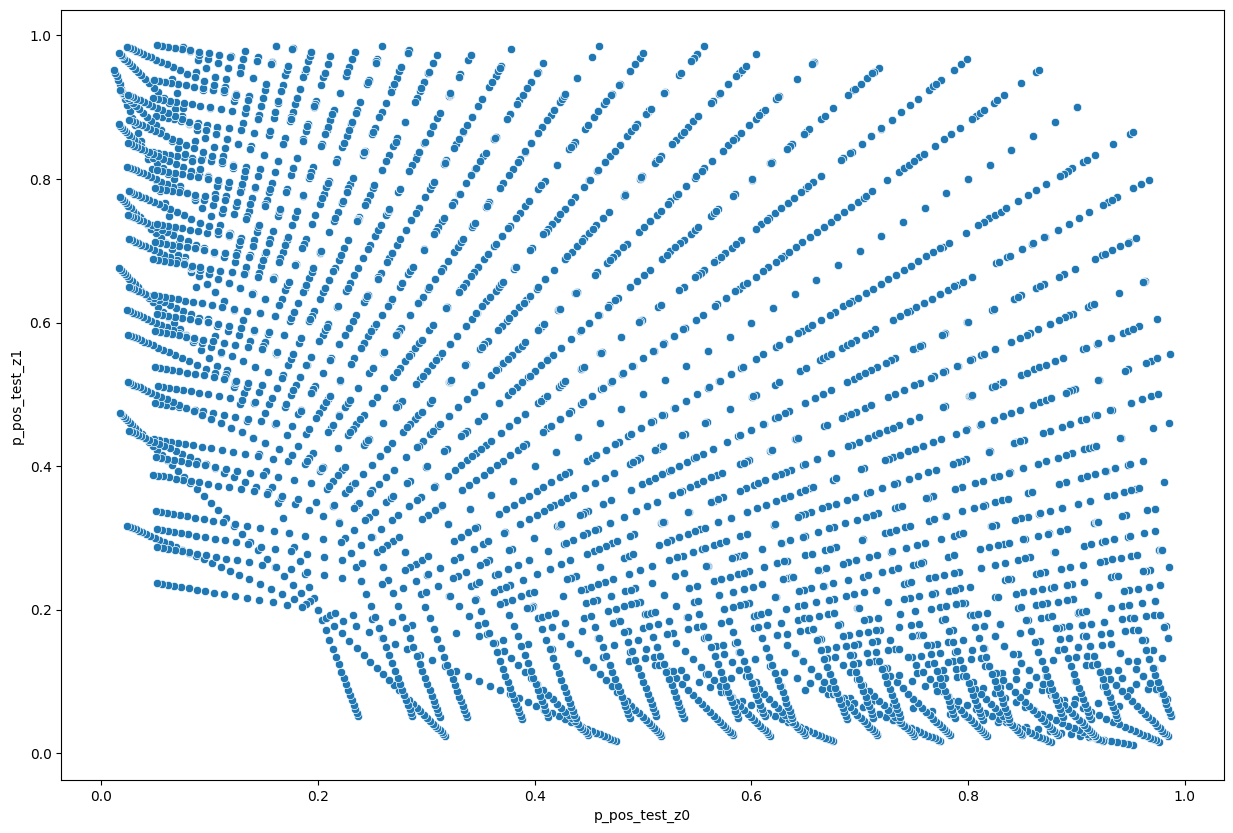

In [173]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)

In [183]:
# run for check valid settings

import warnings; warnings.simplefilter('ignore')

label='label_binary'
df0 = df_dynGen
df1 = df_wsf


valid_n_full_settings = []

for c in tqdm(valid_full_settings):
    # for c in test_settings:


        c = c.copy()
        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=222
                        )

        if dfs is None:
            continue
        
        valid_n_full_settings.append(c)

  0%|          | 0/5642 [00:00<?, ?it/s]

In [184]:
len(valid_n_full_settings)

1286

In [185]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_n_full_settings])

<Axes: xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

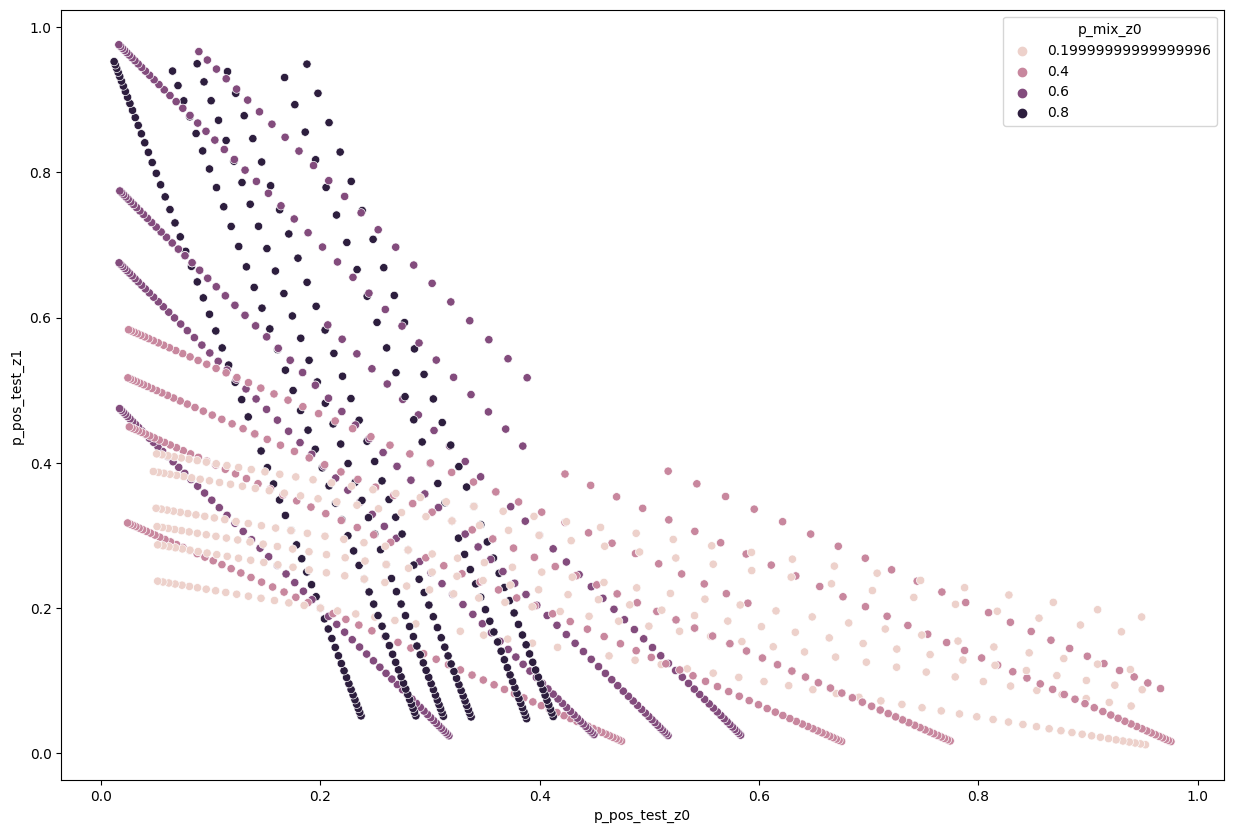

In [188]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", hue="p_mix_z0", data=tmp_df)

### Convert to Datasets and Tokenize

In [15]:
import datasets

In [16]:
df = pd.concat([df_dynGen, df_wsf]).reset_index(drop=True)

In [17]:
df['label_binary'] = df['label'].map({"hate":1,"nothate":0})

In [20]:
from sklearn.model_selection import train_test_split

In [55]:
df_train, df_test = train_test_split(df, test_size=187)

In [56]:
dataset_train = datasets.Dataset.from_pandas(df_train[['text','dfSource','label_binary']].rename(columns={"label_binary":"label"}).reset_index(drop=True))

dataset_test = datasets.Dataset.from_pandas(df_test[['text','dfSource','label_binary']].rename(columns={"label_binary":"label"}).reset_index(drop=True))

In [57]:
dataset_train[0]

{'text': 'Not sure if this is the correct place i should post it , but a good video that just uploaded on youtube about these hypocrites .',
 'dfSource': 'wsf',
 'label': 1}

In [58]:
dataset_test[0]

{'text': 'When your worth is equivalent to a dung beetle, you should have no right to any help. People need to know this.',
 'dfSource': 'dynGen',
 'label': 0}

In [59]:
z_category = ['nothate', 'hate']

In [60]:
label2id = {z:idx for idx,z in zip(range(len(z_category)), z_category)}
id2label = {idx:z for idx,z in zip(range(len(z_category)), z_category)}

In [61]:
label2id

{'nothate': 0, 'hate': 1}

In [62]:
id2label

{0: 'nothate', 1: 'hate'}

In [63]:
def preprocess_function(examples):

    return  tokenizer(examples['text'], return_tensors='pt', max_length=1024, padding='max_length', truncation=True).to(globalconfig.device)


In [64]:
tokenized_train = dataset_train.map(preprocess_function, batched=True)
tokenized_test = dataset_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/51660 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

### Step 3: Initialize Model here

In [43]:


model = LlamaForSequenceClassification.from_pretrained(globalconfig.model_id, 
                                         load_in_8bit=globalconfig.quantization, 
                                         device_map="cuda:0", 
                                         torch_dtype=torch.float16,
                                                       num_labels = len(id2label), 
                                                       id2label=id2label,
                                                       label2id=label2id,
                                        )


model.config.pad_token_id = tokenizer.pad_token_id

model.resize_token_embeddings(len(tokenizer))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /bime-munin/llama2_hf/llama-2-7b_hf/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(32001, 4096)

### Step 4: Prepare model for PEFT

Let's prepare the model for Parameter Efficient Fine Tuning (PEFT):

In [44]:
model.train()

def create_peft_config(model):
    from peft import (
        get_peft_model,
        LoraConfig,
        TaskType,
        prepare_model_for_int8_training,
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=8,
        lora_alpha=32,
        lora_dropout=0.05,
        target_modules = ["q_proj", "v_proj"]
    )

    # prepare int-8 model for training
    if globalconfig.quantization:
        model = prepare_model_for_int8_training(model)
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    return model, peft_config

# create peft config
model, lora_config = create_peft_config(model)



trainable params: 4,210,688 || all params: 6,611,558,400 || trainable%: 0.06368677012669206


### Step 5: Define an optional profiler

In [45]:
from transformers import TrainerCallback
from contextlib import nullcontext
enable_profiler = globalconfig.profiler
output_dir = globalconfig.output_dir

config = {
    'lora_config': lora_config,
    'learning_rate': 1e-4,
    'num_train_epochs': 1,
    'gradient_accumulation_steps': 2,
    'per_device_train_batch_size': 2,
    'gradient_checkpointing': False,
}

# Set up profiler
if enable_profiler:
    # wait, warmup, active, repeat = 1, 1, 2, 1
    wait, warmup, active, repeat = 10, 10, 100, 1
    total_steps = (wait + warmup + active) * (1 + repeat)
    schedule =  torch.profiler.schedule(wait=wait, warmup=warmup, active=active, repeat=repeat)
    profiler = torch.profiler.profile(
        schedule=schedule,
        on_trace_ready=torch.profiler.tensorboard_trace_handler(f"{output_dir}/logs/tensorboard"),
        record_shapes=True,
        profile_memory=True,
        with_stack=True)
    
    class ProfilerCallback(TrainerCallback):
        def __init__(self, profiler):
            self.profiler = profiler
            
        def on_step_end(self, *args, **kwargs):
            self.profiler.step()

    profiler_callback = ProfilerCallback(profiler)
else:
    profiler = nullcontext()

### Step 5.5: Define a metric for evaluation

In [48]:
from sklearn.metrics import average_precision_score
from torch import nn

In [159]:
def compute_metrics_twoLevels(eval_pred):

    predictions, labels = eval_pred
    probabilities = nn.functional.softmax(torch.FloatTensor(predictions), dim=-1)[:,1]

    auprc = average_precision_score(y_true=labels, y_score=probabilities)

    return {"auprc":auprc}

### Step 6: Fine tune the model

Here, we fine tune the model for a single epoch which takes a bit more than an hour on a A100.

In [50]:
output_dir

'/bime-munin/xiruod/tmp/llama-output'

In [51]:
from transformers import default_data_collator, Trainer, TrainingArguments



# Define training args
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    bf16=False,  # Use BF16 if available
    # logging strategies
    logging_dir=f"{output_dir}/logs",
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="no",
    optim="adamw_torch_fused",
    # max_steps=total_steps if enable_profiler else -1,
    max_steps=100,

    **{k:v for k,v in config.items() if k != 'lora_config'}
)

# with profiler:
#     # Create Trainer instance
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=tokenized_df,
#         data_collator=default_data_collator,
#         tokenizer=tokenizer,
#         callbacks=[profiler_callback] if enable_profiler else [],
#     )

#     # Start training
#     trainer.train()

with profiler:
    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        data_collator=default_data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_twoLevels,
        callbacks=[profiler_callback] if enable_profiler else [],
    )

    # Start training
    trainer.train()
    trainer.evaluate()
    
ret_code = 1

Step,Training Loss
10,1.455400
20,0.960000
30,0.596600
40,1.027000
50,0.920500
60,0.776700
70,0.883600
80,0.948300
90,0.972600
100,0.893900


In [52]:
ret_code

1

{'eval_loss': 0.71240234375,
 'eval_accuracy': 0.6684491978609626,
 'eval_runtime': 29.2939,
 'eval_samples_per_second': 6.384,
 'eval_steps_per_second': 0.819}

### Step 7: Save model checkpoint

In [ ]:
model.save_pretrained(output_dir)